In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 8.0MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 10.0MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-04 15:43:26--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-04 15:43:26--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb37c8ef5af230840bf4906e926.dl.dropboxusercontent.com/cd/0/get/BKBzAhVlLqInFSo7lvssL4GOoHLBFQLFrXhu87ZBOhhB2NpQ007zBk9jf55zoVOimWC-xSb8FkReKh-TD2R2ma3n8_t2TnPYn4TvRMqG2YLlpM8rgbtuAMpV0CCHCaCXj7XzSb0-sKaT3l5gIC_kcka0/file?dl=1# [following]
--2021-03-04 15:43:27--  https://ucb37c8ef5af230840bf4906e926.dl.dropboxusercontent.com/cd/0/get/BKBzAhVlLqInFSo7lvssL4GOoHLBFQLFrXhu87ZBOhhB2NpQ007zBk9jf55zoVOi

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo='efficientnet_b0'

## Ranger

In [13]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [11]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=9.12010818865383e-07)

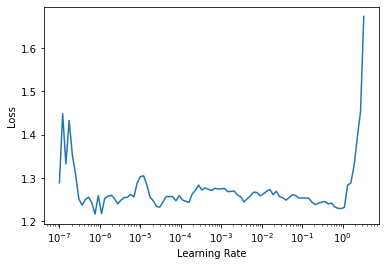

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.328735,0.971145,0.525994,0.514706,0.440252,00:46
1,1.267615,0.951644,0.512232,0.498069,0.405660,00:45


Better model found at epoch 0 with valid_loss value: 0.9711453318595886.


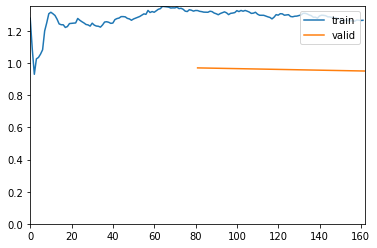

Better model found at epoch 1 with valid_loss value: 0.9516439437866211.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.240761,0.921152,0.521407,0.508897,0.449686,00:57
1,1.214620,0.934996,0.516820,0.503704,0.427673,00:56
2,1.189472,0.886665,0.553517,0.544218,0.503145,00:56
3,1.208827,0.870333,0.533639,0.522034,0.484277,00:56
4,1.181935,0.848630,0.535168,0.525180,0.459119,00:55
5,1.128518,0.830320,0.551988,0.546468,0.462264,00:56
6,1.105321,0.823711,0.545872,0.536585,0.484277,00:56
7,1.041641,0.809017,0.555046,0.546392,0.500000,00:56
8,1.061544,0.804686,0.555046,0.548387,0.481132,00:56
9,1.034542,0.796549,0.547401,0.536913,0.503145,00:56


Better model found at epoch 0 with valid_loss value: 0.9211515188217163.


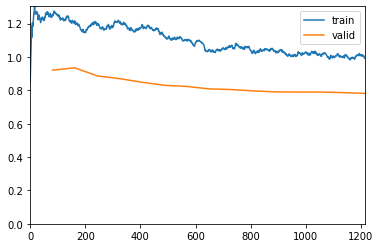

Better model found at epoch 2 with valid_loss value: 0.886664628982544.
Better model found at epoch 3 with valid_loss value: 0.8703327775001526.
Better model found at epoch 4 with valid_loss value: 0.848629891872406.
Better model found at epoch 5 with valid_loss value: 0.8303202390670776.
Better model found at epoch 6 with valid_loss value: 0.8237112164497375.
Better model found at epoch 7 with valid_loss value: 0.8090172410011292.
Better model found at epoch 8 with valid_loss value: 0.8046858906745911.
Better model found at epoch 9 with valid_loss value: 0.7965489029884338.
Better model found at epoch 10 with valid_loss value: 0.7907636165618896.
Better model found at epoch 11 with valid_loss value: 0.7895814776420593.
Better model found at epoch 13 with valid_loss value: 0.7863210439682007.
Better model found at epoch 14 with valid_loss value: 0.7815946936607361.


In [13]:
learn.fine_tune(15,freeze_epochs=2)

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

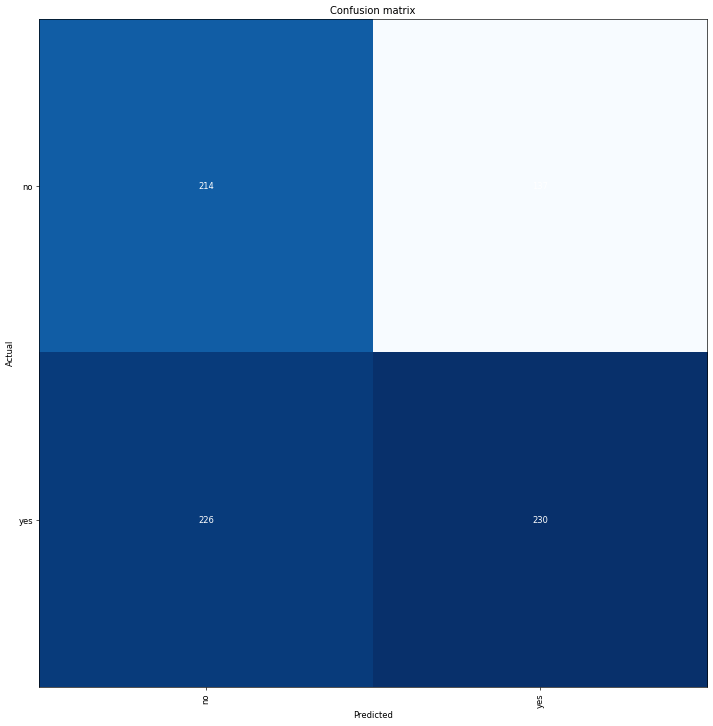

In [15]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5501858592033386.


(#4) [0.7760438323020935,0.5501858592033386,0.6267029972752044,0.5043859649122807]

## Faltten

In [17]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.291833,0.949868,0.547401,0.530387,0.603774,00:46
1,0.973163,0.736060,0.599388,0.576923,0.660377,00:46


Better model found at epoch 0 with valid_loss value: 0.9498675465583801.


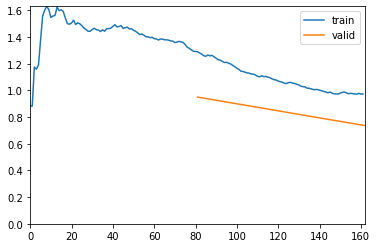

Better model found at epoch 1 with valid_loss value: 0.7360600233078003.


In [18]:
learn.fit_flat_cos(2,lr=1e-3)

In [19]:
learn.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=6.309573450380412e-07)

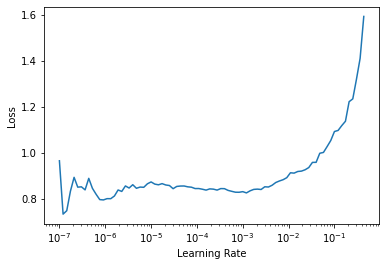

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.018194,1.511208,0.530581,0.517350,0.515723,00:55
1,0.998608,2.428514,0.509174,0.485981,0.163522,00:55
2,0.993870,1.259895,0.478593,0.456929,0.383648,00:55
3,0.934226,0.719460,0.518349,0.524590,0.100629,00:55
4,0.941810,0.698722,0.513761,0.000000,0.000000,00:55
5,1.092989,4.497663,0.501529,0.493485,0.952830,00:55
6,0.993123,0.764104,0.507645,0.496721,0.952830,00:55
7,0.945046,0.775737,0.484709,0.484992,0.965409,00:55


Better model found at epoch 0 with valid_loss value: 1.5112082958221436.


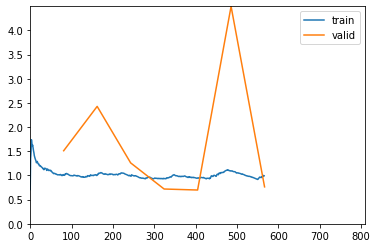

Better model found at epoch 2 with valid_loss value: 1.2598950862884521.
Better model found at epoch 3 with valid_loss value: 0.7194596529006958.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 4 with valid_loss value: 0.6987219452857971.
No improvement since epoch 4: early stopping


In [21]:
learn.fit_flat_cos(10,lr=1e-2)

In [22]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


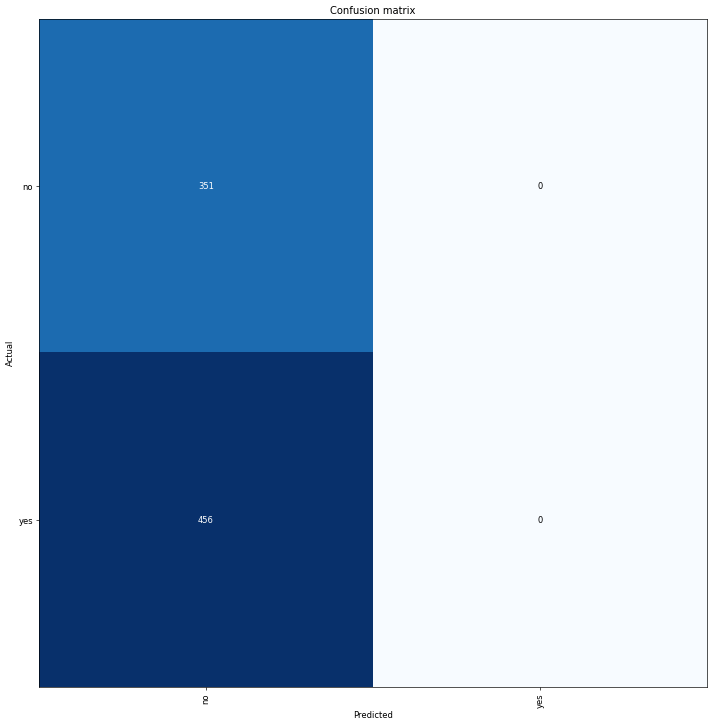

In [23]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [24]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.7316663861274719,0.4349442422389984,0.0,0.0]

## LabelSmoothing

In [25]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=1.3182567499825382e-06)

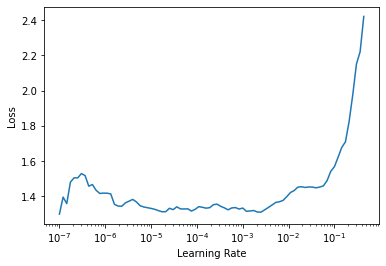

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.324940,1.000414,0.574924,0.551546,0.672956,00:46
1,1.079805,0.761525,0.573394,0.546318,0.723270,00:46


Better model found at epoch 0 with valid_loss value: 1.0004141330718994.


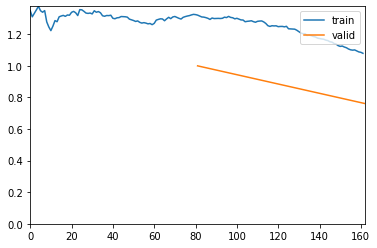

Better model found at epoch 1 with valid_loss value: 0.7615245580673218.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.801046,0.684624,0.617737,0.590426,0.698113,00:56
1,0.748164,0.688285,0.608563,0.578283,0.720126,00:56
2,0.721355,0.717652,0.551988,0.527964,0.742138,00:56
3,0.701752,0.673459,0.600917,0.570370,0.726415,00:56
4,0.679679,0.652476,0.640673,0.624625,0.654088,00:56
5,0.660636,0.650697,0.655963,0.689796,0.531447,00:56
6,0.648890,0.645407,0.648318,0.692982,0.496855,00:56
7,0.639506,0.629047,0.654434,0.641975,0.654088,00:56
8,0.632444,0.636721,0.619266,0.621053,0.556604,00:56
9,0.621311,0.628154,0.666667,0.647059,0.691824,00:56


Better model found at epoch 0 with valid_loss value: 0.6846235394477844.


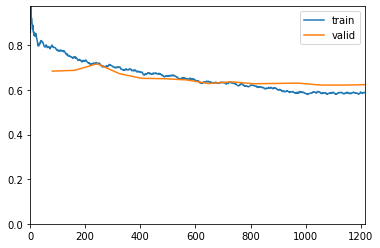

Better model found at epoch 3 with valid_loss value: 0.6734592318534851.
Better model found at epoch 4 with valid_loss value: 0.6524755954742432.
Better model found at epoch 5 with valid_loss value: 0.6506970524787903.
Better model found at epoch 6 with valid_loss value: 0.6454071998596191.
Better model found at epoch 7 with valid_loss value: 0.6290472745895386.
Better model found at epoch 9 with valid_loss value: 0.6281543970108032.
Better model found at epoch 12 with valid_loss value: 0.6222296953201294.
Better model found at epoch 13 with valid_loss value: 0.6220242381095886.


In [27]:
learn.fine_tune(15,freeze_epochs=2)

In [28]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

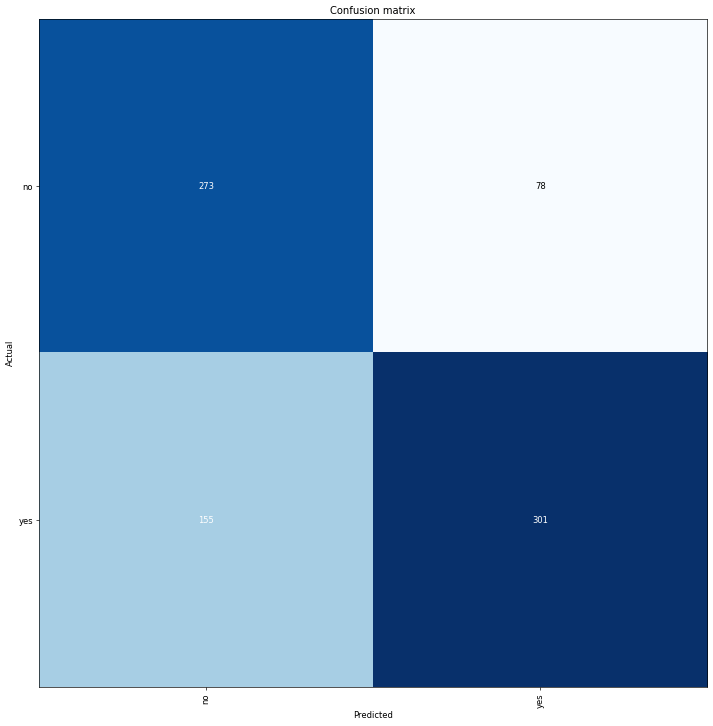

In [29]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [30]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7112763524055481.


(#4) [0.588265597820282,0.7112763524055481,0.7941952506596306,0.6600877192982456]

## MixUp

In [12]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [32]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.248048,1.091784,0.545872,0.553846,0.339623,00:49
1,1.072343,0.775352,0.551988,0.533333,0.628931,00:49


Better model found at epoch 0 with valid_loss value: 1.0917842388153076.


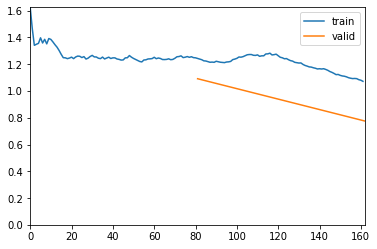

Better model found at epoch 1 with valid_loss value: 0.7753521800041199.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.820636,0.713319,0.581040,0.603774,0.402516,00:58
1,0.775722,0.682483,0.590214,0.621359,0.402516,00:58
2,0.740559,0.674055,0.574924,0.567568,0.528302,00:58
3,0.710822,0.666472,0.614679,0.625000,0.518868,00:58
4,0.686548,0.691580,0.581040,0.583333,0.484277,00:58
5,0.676103,0.675093,0.611621,0.663265,0.408805,00:58
6,0.675689,0.657294,0.602446,0.621849,0.465409,00:59
7,0.665857,0.635988,0.634557,0.651341,0.534591,00:58
8,0.658711,0.634386,0.631498,0.663830,0.490566,00:59
9,0.631489,0.622852,0.633027,0.641304,0.556604,00:59


Better model found at epoch 0 with valid_loss value: 0.7133194208145142.


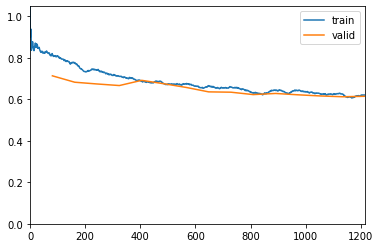

Better model found at epoch 1 with valid_loss value: 0.6824831962585449.
Better model found at epoch 2 with valid_loss value: 0.6740550398826599.
Better model found at epoch 3 with valid_loss value: 0.6664720177650452.
Better model found at epoch 6 with valid_loss value: 0.657293975353241.
Better model found at epoch 7 with valid_loss value: 0.6359884738922119.
Better model found at epoch 8 with valid_loss value: 0.6343860626220703.
Better model found at epoch 9 with valid_loss value: 0.6228523850440979.
Better model found at epoch 11 with valid_loss value: 0.6218389868736267.
Better model found at epoch 12 with valid_loss value: 0.6163599491119385.
Better model found at epoch 13 with valid_loss value: 0.6124663352966309.


In [33]:
learn.fine_tune(15,freeze_epochs=2)

In [34]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

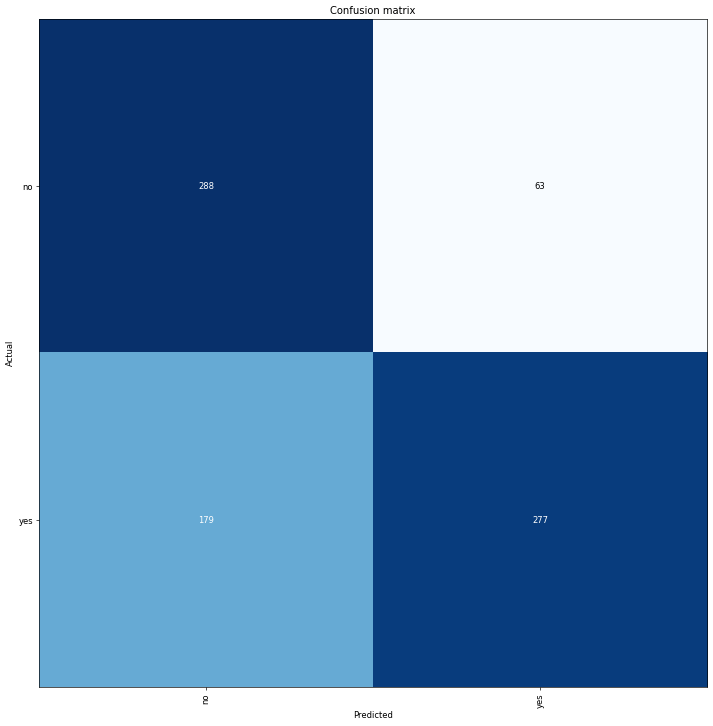

In [35]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [36]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7001239061355591.


(#4) [0.5822980999946594,0.7001239061355591,0.8147058823529412,0.6074561403508771]

## Ranger + Flat cosin Anneal

In [37]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.280899,0.948340,0.483180,0.468153,0.462264,00:46
1,1.175146,0.908319,0.496942,0.483965,0.522013,00:46


Better model found at epoch 0 with valid_loss value: 0.9483403563499451.


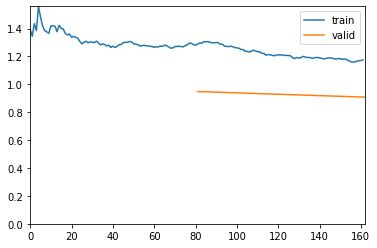

Better model found at epoch 1 with valid_loss value: 0.9083190560340881.


In [38]:
learn.fit_flat_cos(2,lr=1e-3)

In [39]:
learn.unfreeze()

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=3.981071586167673e-06)

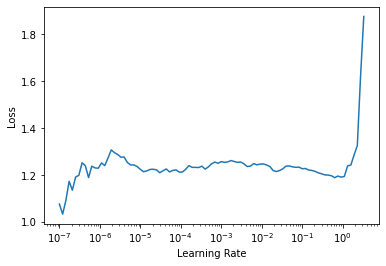

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.152931,0.747115,0.564220,0.559567,0.487421,00:56
1,0.981259,0.707056,0.605505,0.602041,0.556604,00:56
2,0.879369,0.676607,0.597859,0.587859,0.578616,00:57
3,0.799155,0.645152,0.651376,0.647059,0.622642,00:56
4,0.708290,0.624467,0.681957,0.716535,0.572327,00:57
5,0.676109,0.615146,0.672783,0.683099,0.610063,00:57
6,0.647470,0.614513,0.675841,0.732456,0.525157,00:57
7,0.619123,0.619118,0.671254,0.756219,0.477987,00:57
8,0.604283,0.611879,0.669725,0.736111,0.500000,00:57
9,0.589016,0.608374,0.674312,0.737557,0.512579,00:57


Better model found at epoch 0 with valid_loss value: 0.7471149563789368.


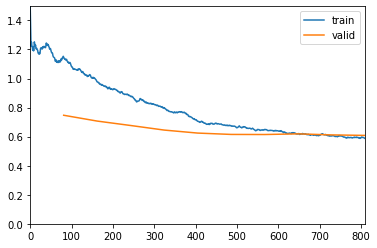

Better model found at epoch 1 with valid_loss value: 0.7070562243461609.
Better model found at epoch 2 with valid_loss value: 0.676607072353363.
Better model found at epoch 3 with valid_loss value: 0.6451518535614014.
Better model found at epoch 4 with valid_loss value: 0.6244667172431946.
Better model found at epoch 5 with valid_loss value: 0.6151464581489563.
Better model found at epoch 6 with valid_loss value: 0.6145125031471252.
Better model found at epoch 8 with valid_loss value: 0.611879289150238.
Better model found at epoch 9 with valid_loss value: 0.6083744168281555.


In [41]:
learn.fit_flat_cos(10,lr=1e-2)

In [42]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [43]:
learn.dls = dlsTest

In [44]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7001239061355591.


(#4) [0.565496027469635,0.7001239061355591,0.834375,0.5855263157894737]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [45]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.311270,1.006951,0.486239,0.478261,0.622642,00:47
1,1.324889,0.973651,0.472477,0.465473,0.572327,00:47


Better model found at epoch 0 with valid_loss value: 1.0069506168365479.


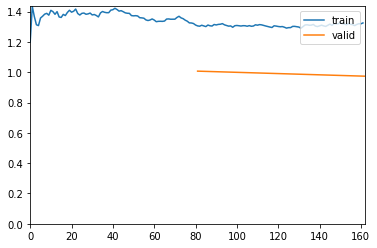

Better model found at epoch 1 with valid_loss value: 0.9736507534980774.


In [46]:
learn.fit_flat_cos(2,lr=1e-3)

In [47]:
learn.unfreeze()

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=9.999999747378752e-06)

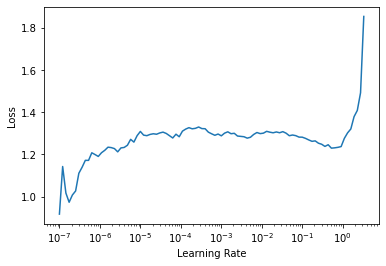

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.190702,0.843196,0.525994,0.513514,0.477987,00:57
1,1.075012,0.743494,0.570336,0.572549,0.459119,00:57
2,0.945274,0.687975,0.577982,0.567742,0.553459,00:57
3,0.839514,0.645046,0.628440,0.636364,0.550314,00:57
4,0.757025,0.651251,0.634557,0.629508,0.603774,00:57
5,0.706640,0.636466,0.652905,0.651163,0.616352,00:57
6,0.681524,0.615948,0.675841,0.693431,0.597484,00:57
7,0.648549,0.615637,0.659021,0.673993,0.578616,00:57
8,0.646559,0.619145,0.674312,0.661538,0.676101,00:57
9,0.642284,0.609337,0.688073,0.714286,0.597484,00:57


Better model found at epoch 0 with valid_loss value: 0.8431962728500366.


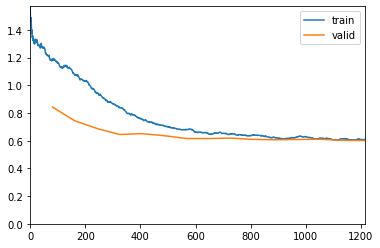

Better model found at epoch 1 with valid_loss value: 0.7434937953948975.
Better model found at epoch 2 with valid_loss value: 0.6879746913909912.
Better model found at epoch 3 with valid_loss value: 0.6450464725494385.
Better model found at epoch 5 with valid_loss value: 0.6364660263061523.
Better model found at epoch 6 with valid_loss value: 0.6159483790397644.
Better model found at epoch 7 with valid_loss value: 0.615637481212616.
Better model found at epoch 9 with valid_loss value: 0.6093373894691467.
Better model found at epoch 10 with valid_loss value: 0.6070936322212219.
Better model found at epoch 13 with valid_loss value: 0.6029661893844604.
Better model found at epoch 14 with valid_loss value: 0.6010814309120178.


In [49]:
learn.fit_flat_cos(15,lr=1e-2)

In [50]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [51]:
learn.dls = dlsTest

In [52]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7050805687904358.


(#4) [0.59354168176651,0.7050805687904358,0.8132183908045977,0.6206140350877193]

## Ranger +Flat + Label + MixUp

In [53]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.264625,0.964267,0.507645,0.495652,0.716981,00:47
1,1.248894,0.933747,0.509174,0.496788,0.729560,00:47


Better model found at epoch 0 with valid_loss value: 0.9642668962478638.


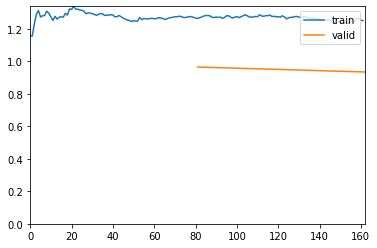

Better model found at epoch 1 with valid_loss value: 0.9337471127510071.


In [54]:
learn.fit_flat_cos(2,lr=1e-3)

In [55]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.158912,0.747950,0.574924,0.558824,0.597484,00:57
1,1.045295,0.752884,0.555046,0.529801,0.754717,00:57
2,0.910424,0.696767,0.597859,0.574932,0.663522,00:57
3,0.830540,0.682406,0.607034,0.602007,0.566038,00:57
4,0.770123,0.667587,0.594801,0.612766,0.452830,00:57
5,0.728354,0.651063,0.640673,0.655431,0.550314,00:57
6,0.697879,0.641822,0.642202,0.666667,0.528302,00:57
7,0.685424,0.640182,0.637615,0.641115,0.578616,00:57
8,0.671897,0.632978,0.645260,0.665385,0.544025,00:57
9,0.664164,0.633075,0.654434,0.652318,0.619497,00:57


Better model found at epoch 0 with valid_loss value: 0.7479500770568848.


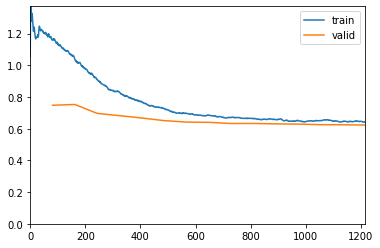

Better model found at epoch 2 with valid_loss value: 0.6967670917510986.
Better model found at epoch 3 with valid_loss value: 0.6824058890342712.
Better model found at epoch 4 with valid_loss value: 0.6675870418548584.
Better model found at epoch 5 with valid_loss value: 0.651062548160553.
Better model found at epoch 6 with valid_loss value: 0.6418215036392212.
Better model found at epoch 7 with valid_loss value: 0.6401822566986084.
Better model found at epoch 8 with valid_loss value: 0.632978081703186.
Better model found at epoch 10 with valid_loss value: 0.6304811835289001.
Better model found at epoch 11 with valid_loss value: 0.6291430592536926.
Better model found at epoch 12 with valid_loss value: 0.6254122853279114.
Better model found at epoch 13 with valid_loss value: 0.6248160004615784.
Better model found at epoch 14 with valid_loss value: 0.6232357025146484.


In [56]:
learn.fit_flat_cos(15,lr=1e-2)

In [57]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

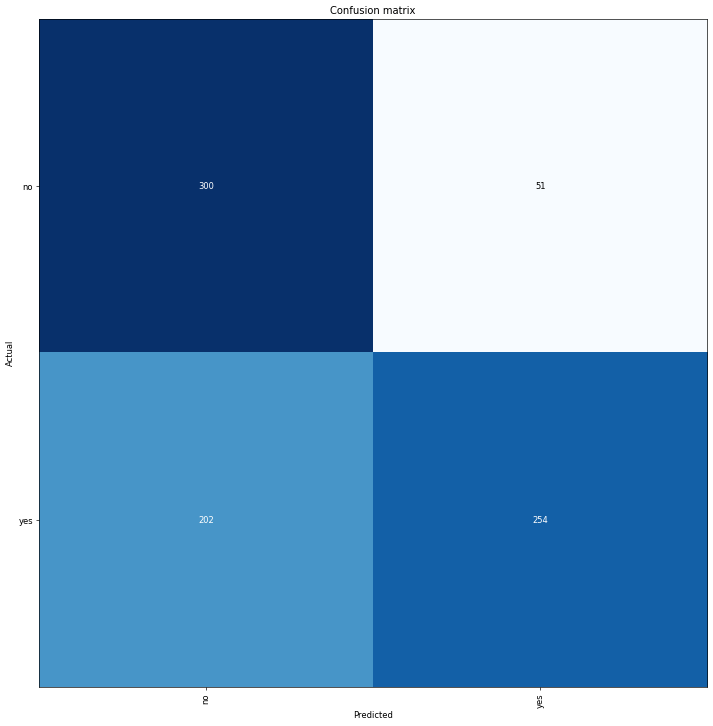

In [58]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [59]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6864931583404541.


(#4) [0.6087712645530701,0.6864931583404541,0.8327868852459016,0.5570175438596491]

## Ranger + Flat + MixUp

In [60]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [61]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.330456,1.007180,0.507645,0.495261,0.657233,00:46
1,1.251969,0.979508,0.498471,0.487685,0.622642,00:46


Better model found at epoch 0 with valid_loss value: 1.007179617881775.


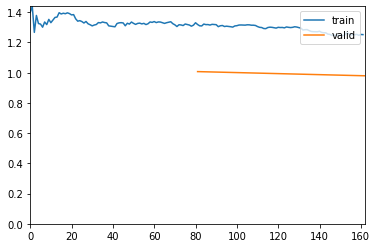

Better model found at epoch 1 with valid_loss value: 0.9795077443122864.


In [62]:
learn.fit_flat_cos(2,lr=1e-3)

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.173633,0.824839,0.529052,0.511364,0.707547,00:56
1,1.059438,0.733340,0.544343,0.527027,0.613208,00:57
2,0.945556,0.715124,0.584098,0.549356,0.805031,00:57
3,0.837703,0.666749,0.584098,0.569277,0.594340,00:57
4,0.754989,0.652481,0.607034,0.581333,0.685535,00:57
5,0.710900,0.630967,0.643731,0.617080,0.704403,00:57
6,0.690226,0.615657,0.654434,0.642857,0.650943,00:57
7,0.662675,0.609341,0.662080,0.645646,0.676101,00:57
8,0.658717,0.616127,0.662080,0.629333,0.742138,00:57
9,0.640991,0.600460,0.678899,0.677632,0.647799,00:57


Better model found at epoch 0 with valid_loss value: 0.8248394727706909.


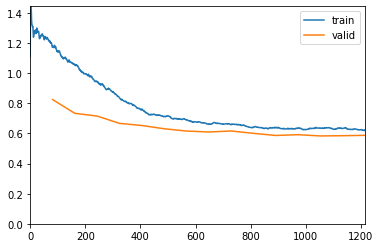

Better model found at epoch 1 with valid_loss value: 0.7333400845527649.
Better model found at epoch 2 with valid_loss value: 0.71512371301651.
Better model found at epoch 3 with valid_loss value: 0.6667494773864746.
Better model found at epoch 4 with valid_loss value: 0.652481198310852.
Better model found at epoch 5 with valid_loss value: 0.630967378616333.
Better model found at epoch 6 with valid_loss value: 0.6156569123268127.
Better model found at epoch 7 with valid_loss value: 0.6093410849571228.
Better model found at epoch 9 with valid_loss value: 0.6004601716995239.
Better model found at epoch 10 with valid_loss value: 0.586336612701416.
Better model found at epoch 12 with valid_loss value: 0.5832298994064331.


In [64]:
learn.fit_flat_cos(15,lr=1e-2)

In [65]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [66]:
learn.dls = dlsTest

In [67]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7286245226860046.


(#4) [0.5601996183395386,0.7286245226860046,0.8110236220472441,0.6776315789473685]

## Ranger + MixUp

In [68]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [69]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.351733,1.024752,0.498471,0.488038,0.641509,00:46
1,1.294740,0.942812,0.512232,0.498674,0.591195,00:46


Better model found at epoch 0 with valid_loss value: 1.0247524976730347.


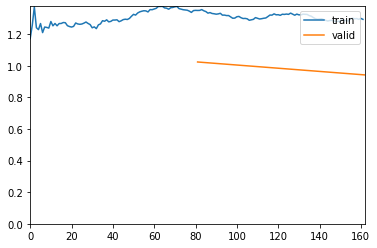

Better model found at epoch 1 with valid_loss value: 0.9428116679191589.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.242926,0.929789,0.513761,0.500000,0.572327,00:56
1,1.212589,0.930723,0.510703,0.497340,0.588050,00:56
2,1.230144,0.917681,0.506116,0.493188,0.569182,00:57
3,1.214565,0.889485,0.525994,0.511429,0.562893,00:57
4,1.193334,0.857430,0.518349,0.504110,0.578616,00:57
5,1.179068,0.843547,0.516820,0.502976,0.531447,00:57
6,1.110421,0.819653,0.515290,0.501511,0.522013,00:56
7,1.088759,0.821815,0.527523,0.515152,0.481132,00:57
8,1.059976,0.808242,0.530581,0.517028,0.525157,00:57
9,1.090389,0.804231,0.532110,0.518072,0.540881,00:57


Better model found at epoch 0 with valid_loss value: 0.929789125919342.


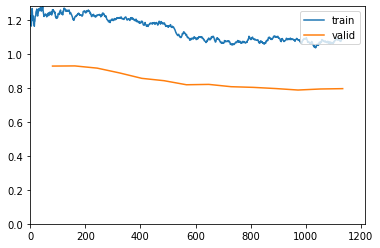

Better model found at epoch 2 with valid_loss value: 0.9176812171936035.
Better model found at epoch 3 with valid_loss value: 0.8894852995872498.
Better model found at epoch 4 with valid_loss value: 0.857430100440979.
Better model found at epoch 5 with valid_loss value: 0.843546986579895.
Better model found at epoch 6 with valid_loss value: 0.819652795791626.
Better model found at epoch 8 with valid_loss value: 0.8082415461540222.
Better model found at epoch 9 with valid_loss value: 0.8042305111885071.
Better model found at epoch 10 with valid_loss value: 0.7972857356071472.
Better model found at epoch 11 with valid_loss value: 0.7885631918907166.
No improvement since epoch 11: early stopping


In [70]:
learn.fine_tune(15,freeze_epochs=2)

In [71]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [72]:
learn.dls = dlsTest

In [73]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5935564041137695.


(#4) [0.715168833732605,0.5935564041137695,0.6516587677725119,0.6030701754385965]

## Faltten + MixUp

In [14]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.250479,0.912704,0.538226,0.520619,0.635220,00:24
1,0.974649,0.722563,0.577982,0.577778,0.490566,00:24


Better model found at epoch 0 with valid_loss value: 0.9127036929130554.


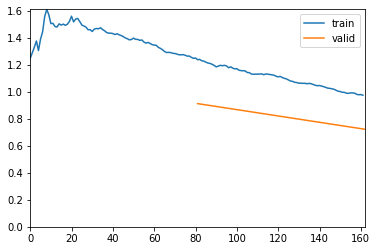

Better model found at epoch 1 with valid_loss value: 0.7225630879402161.


In [15]:
learn.fit_flat_cos(2,lr=1e-3)

In [16]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.995383,9.378919,0.483180,0.472973,0.550314,00:26
1,0.999696,0.744736,0.510703,0.498252,0.896226,00:25
2,1.179412,29.450655,0.513761,0.000000,0.000000,00:25
3,1.135273,27.487268,0.487768,0.486903,0.993711,00:25
4,1.004974,1.046036,0.495413,0.485646,0.638365,00:25


Better model found at epoch 0 with valid_loss value: 9.378918647766113.


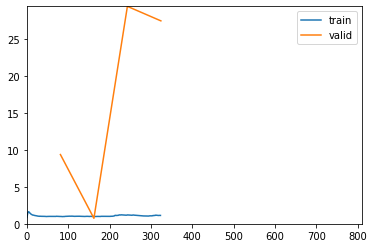

Better model found at epoch 1 with valid_loss value: 0.7447360157966614.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


No improvement since epoch 1: early stopping


In [17]:
learn.fit_flat_cos(10,lr=1e-2)

In [18]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [19]:
learn.dls = dlsTest

In [20]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5365551710128784.


(#4) [0.7301986813545227,0.5365551710128784,0.556786703601108,0.881578947368421]

## Ranger + Label

In [21]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [22]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.314118,0.942914,0.551988,0.533693,0.622642,00:24
1,1.270530,0.907739,0.539755,0.524355,0.575472,00:24


Better model found at epoch 0 with valid_loss value: 0.9429144859313965.


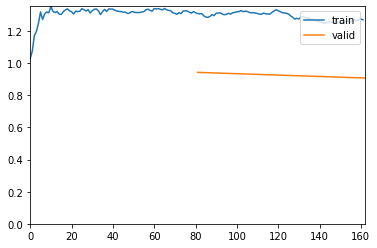

Better model found at epoch 1 with valid_loss value: 0.9077389240264893.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.236704,0.892128,0.551988,0.534060,0.616352,00:26
1,1.216030,0.895472,0.551988,0.535613,0.591195,00:26
2,1.188275,0.884464,0.553517,0.537572,0.584906,00:26
3,1.173578,0.863757,0.553517,0.540373,0.547170,00:26
4,1.125769,0.843946,0.562691,0.551282,0.540881,00:26
5,1.123858,0.827371,0.576453,0.568106,0.537736,00:26
6,1.109401,0.806075,0.574924,0.569444,0.515723,00:26
7,1.089494,0.798572,0.582569,0.575251,0.540881,00:26
8,1.082124,0.785563,0.579511,0.567823,0.566038,00:27
9,1.084711,0.786749,0.568807,0.557692,0.547170,00:26


Better model found at epoch 0 with valid_loss value: 0.8921279311180115.


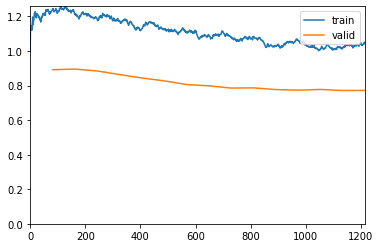

Better model found at epoch 2 with valid_loss value: 0.8844637870788574.
Better model found at epoch 3 with valid_loss value: 0.8637566566467285.
Better model found at epoch 4 with valid_loss value: 0.8439462780952454.
Better model found at epoch 5 with valid_loss value: 0.8273714184761047.
Better model found at epoch 6 with valid_loss value: 0.8060749769210815.
Better model found at epoch 7 with valid_loss value: 0.798572301864624.
Better model found at epoch 8 with valid_loss value: 0.7855627536773682.
Better model found at epoch 10 with valid_loss value: 0.7769063711166382.
Better model found at epoch 11 with valid_loss value: 0.7732565999031067.
Better model found at epoch 13 with valid_loss value: 0.7714376449584961.


In [23]:
learn.fine_tune(15,freeze_epochs=2)

In [24]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [25]:
learn.dls = dlsTest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5526641607284546.


(#4) [0.7910352945327759,0.5526641607284546,0.6330532212885154,0.4956140350877193]

## Faltten + Label

In [27]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.244411,0.790101,0.590214,0.569832,0.641509,00:24
1,0.938879,0.695762,0.607034,0.592145,0.616352,00:24


Better model found at epoch 0 with valid_loss value: 0.7901014089584351.


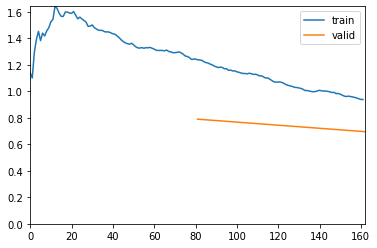

Better model found at epoch 1 with valid_loss value: 0.6957621574401855.


In [28]:
learn.fit_flat_cos(2,lr=1e-3)

In [29]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=0.002511886414140463)

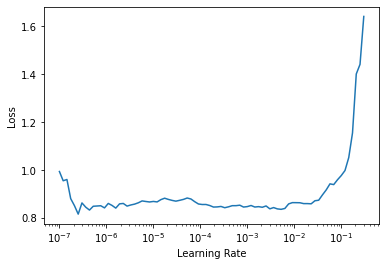

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.008915,57.858158,0.490826,0.346939,0.053459,00:26
1,1.016667,12.651742,0.472477,0.477080,0.883648,00:25
2,1.006356,0.693368,0.504587,0.476190,0.188679,00:26
3,1.053454,4.799073,0.486239,0.482490,0.779874,00:26
4,1.054569,0.700990,0.513761,0.500000,0.006289,00:26
5,1.105046,13.291203,0.495413,0.489510,0.880503,00:26


Better model found at epoch 0 with valid_loss value: 57.858158111572266.


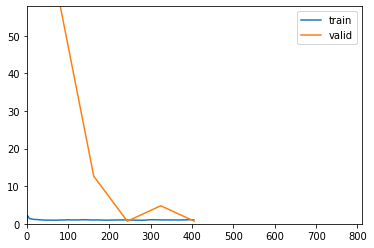

Better model found at epoch 1 with valid_loss value: 12.651741981506348.
Better model found at epoch 2 with valid_loss value: 0.6933678984642029.
No improvement since epoch 2: early stopping


In [31]:
learn.fit_flat_cos(10,lr=1e-2)

In [32]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [33]:
learn.dls = dlsTest

In [34]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4436183273792267.


(#4) [0.698404848575592,0.4436183273792267,0.5238095238095238,0.16885964912280702]

## Label + MixUp

In [35]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.283584,1.034850,0.541284,0.534091,0.443396,00:24
1,1.078442,0.750197,0.555046,0.536193,0.628931,00:24


Better model found at epoch 0 with valid_loss value: 1.034850001335144.


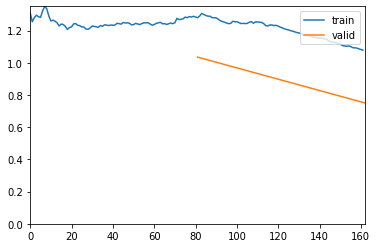

Better model found at epoch 1 with valid_loss value: 0.7501974105834961.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.793014,0.682028,0.579511,0.578182,0.500000,00:26
1,0.759254,0.684372,0.590214,0.581699,0.559748,00:26
2,0.731306,0.681604,0.590214,0.600000,0.471698,00:26
3,0.708341,0.657560,0.614679,0.673684,0.402516,00:26
4,0.697729,0.669170,0.611621,0.582051,0.713836,00:26
5,0.692714,0.655746,0.617737,0.610390,0.591195,00:26
6,0.679029,0.651383,0.629969,0.610465,0.660377,00:26
7,0.669417,0.647987,0.645260,0.706731,0.462264,00:26
8,0.668913,0.651278,0.626911,0.668182,0.462264,00:26
9,0.659293,0.638349,0.654434,0.672932,0.562893,00:26


Better model found at epoch 0 with valid_loss value: 0.6820278167724609.


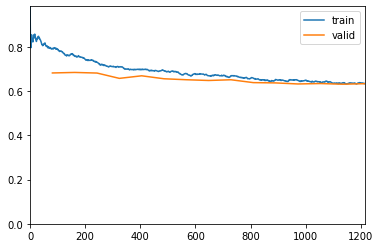

Better model found at epoch 2 with valid_loss value: 0.6816043853759766.
Better model found at epoch 3 with valid_loss value: 0.6575603485107422.
Better model found at epoch 5 with valid_loss value: 0.6557459235191345.
Better model found at epoch 6 with valid_loss value: 0.6513829827308655.
Better model found at epoch 7 with valid_loss value: 0.6479867100715637.
Better model found at epoch 9 with valid_loss value: 0.6383489370346069.
Better model found at epoch 10 with valid_loss value: 0.637021005153656.
Better model found at epoch 11 with valid_loss value: 0.6322875022888184.
Better model found at epoch 13 with valid_loss value: 0.6311821937561035.


In [36]:
learn.fine_tune(15,freeze_epochs=2)

In [37]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [38]:
learn.dls = dlsTest

In [39]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6864931583404541.


(#4) [0.6089876294136047,0.6864931583404541,0.8201892744479495,0.5701754385964912]